# Example of a close loop using the SPICA-FT algorithm

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# skeleton is the main module, contains for example the function for running the loop.
import cophasim.skeleton as sk 

# coh_tools contains useful tools, for generating the spectral sample for example.
import cophasim.coh_tools as ct 

# config contains all the parameters describing the interferometer (number of telescopes, observed object, 
# spectral sampling, etc..) and setup (Fringe-Sensor and Fringe-Tracker).
from cophasim import config 

from cophasim.tol_colors import tol_cset # Colorblind-friendly and high-contrast library for my plots
colors=tol_cset('muted')

dataPack = 'C:/Users/cpannetier/Documents/Python_packages/cophaSIM/cophasim/data/'
dataSim = 'C:/Users/cpannetier/Documents/These/FringeTracking/Python/Simulations/data/'

plt.close('all')

1. __Generation of the spectral sampling.__

We define it by the two extreme wavelength and we can choose the number of spectral channel (MW) or the spectral resolution (R). 

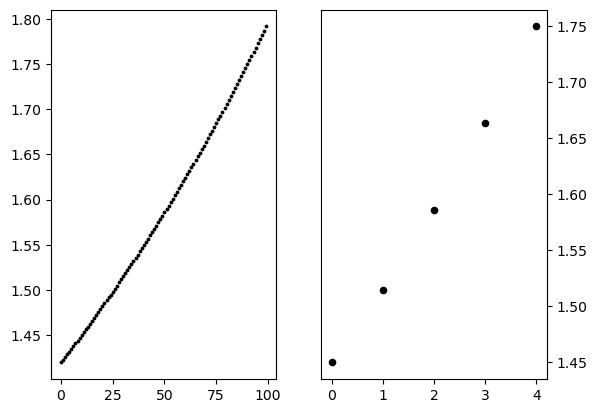

In [2]:
lmbda1 = 1.45
lmbda2 = 1.75
# MW=10
R = 25
OW=20
spectra, spectraM = ct.generate_spectra(lmbda1, lmbda2, OW=OW, R=R, mode='linear_sig')

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.scatter(np.arange(len(spectra)), spectra, color='k', label='Micro', s=3)
ax2.scatter(np.arange(len(spectraM)), spectraM, color='k', label='Macro', s=20)
ax2.yaxis.tick_right()

A little problem of continuity in the micro sampling that I just noticed. Need to be fixed but no major consequence.

2. __Define the fringe-sensor used__

In [3]:
from cophasim.ALTERNATIVE_FS import PAIRWISE
InterfName = "CHARA_6T"
InterferometerFile = dataPack+f'interferometers/{InterfName}.fits'

%matplotlib qt
PAIRWISE(init=True,spectra=spectra, spectraM=spectraM, description="PW6-15-10",
         modulation='ABCD',ArrayDetails=InterferometerFile)#,display=True,savedir=f'./{InterfName}/',ext=['png','pdf'])

NINmes = config.FS['NINmes']; NCmes = config.FS['NCmes']
config.FS['ron'] = 0.5
print(f"Number of measured bases: {NINmes}")
print(f"Number of closures phases: {NCmes}")

Camera C-RED ONE set to gain 150 and noises parameters as follow (from Lanthermann 2019 and its thesis):
              - Readout noise: 0.5 e/pix
              - Excess Noise Factor: 1.47
              - Optics transmission: 0.81
              - Quantum efficiency: 0.7
              - System gain: 0.49 ADU/e
              - Avalanche gain: 150
              - Total gain: 73.5 ADU/e
Number of measured bases: 15
Number of closures phases: 20


plt.figure(); plt.imshow(config.FS['Piston2OPD_r']); plt.show()

The default parameters of the chosen fringe-sensor have been saved in the config module.

3. __Define the interferometer and simulation parameters__

In [4]:
""" Initialise the simulation configurations """

InterfName = "CHARA_6T"
ObservationFile = dataSim+f'observations/{InterfName}/SimpleStar_mag2Diam1.fits'
ObservationFile = dataSim+f'observations/{InterfName}/Unresolved/magH0_0.fits'
Disturbancedir=dataSim+f'disturbances/'
DisturbanceFile = Disturbancedir+'TestMROI/step1_5microns.fits'
DisturbanceFile = Disturbancedir+f'for_optim/CHARA_6T/good/sample0.fits'

# Configuration parameters
NT = 500                # Duration of the simulation [frames]
dt = 2                  # Time of a frame [ms]
latencytime = 2*dt      # Latency of the system
TELref = 1              # If 0, all telescope move. If ia!=0, Tel ia static

# Initialize global coh variable
sk.initialize(InterferometerFile, ObservationFile, DisturbanceFile, NT=NT,
              spectra=spectra, spectraM=spectraM,
              TELref=TELref, dt = dt,
              starttracking=0,latencytime=latencytime, piston_average=1)

# Add noise
config.noise = True

The config module contains the necessary information defining the inteferometer and the simulation:

In [5]:
print(f"For example:\n\
    - Observation File: .../{'/'.join(config.ObservationFile.split('/')[-4:])}\n\
    - Duration of the simulation: {config.NT} frames ; {config.NT*config.dt} ms\n\
    - Latency: {latencytime} ms \n\
    - Noises: {config.noise} ; RON={config.ron}e")

For example:
    - Observation File: .../observations/CHARA_6T/Unresolved/magH0_0.fits
    - Duration of the simulation: 500 frames ; 1000 ms
    - Latency: 4 ms 
    - Noises: True ; RON=2e


4. __Define the Fringe-Tracker__

In [6]:
#NINmes=45
# Basic parameters: Gains and integration time of the GD estimator
GainGD = 0.04 ; GainPD = 0.6

# GD control loop definition
Ngd = 40 ; Ncross=1
roundGD='round' ; Threshold = True

# Search command definition
search=False; SMdelay = .6 ; Sweep0=20 ; Sweep30s=10 ; Slope=.100   # Defines the u_saw function
#Vfactors = np.array([-24.9, -23.9, -18.9, -14.9,  -1.9,   1.1,   9.1,  16.1,  28.1, 30.1])

# Closure phase estimation
CPref=True ; Ncp=300 ; # Impact on the Closure Phase estimation

# Weighting with the baselines SNR
useWmatrices=True ; whichSNR='gd'

# State-Machine thresholds
ThresholdGD = np.ones(NINmes)*10 ; ThresholdPD = 1.5

# Initialize the fringe tracker with the all the parameters above
from cophasim.SPICA_FT import SPICAFT
SPICAFT(init=True, Ngd=Ngd, GainPD=GainPD, GainGD=GainGD, roundGD=roundGD,
        Ncross=Ncross,whichSNR=whichSNR,stdCP=0.2*np.pi,
        search=search,SMdelay=SMdelay,Sweep0=Sweep0,Sweep30s=Sweep30s,Slope=Slope,#Vfactors=Vfactors,
        CPref=CPref,Ncp=Ncp,ThresholdGD=ThresholdGD,ThresholdPD=ThresholdPD,
        Threshold=Threshold,useWmatrices=useWmatrices)

5. __Run a scan of the coherence envelop to evaluate the signal-to-noise regim__ and set the detection threshold of the fringes.

In [7]:
ScanEnvelop=False
if ScanEnvelop:
    from cophasim.SPICA_FT import SetThreshold
    ChosenThresholdGD = SetThreshold(TypeDisturbance="CophasedThenForeground",
                                     manual=False, scan=False,verbose=True,display=True)

6. __Observe the results__

In [ ]:
sk.loop(verbose=True)

Reloading outputs for reinitialising the observables.
We subtract to the piston of each telescope its first value
Processing simulation ...


In [ ]:
sk.display(topAxe='dispersion')